In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pwd = !pwd

In [4]:
matches = pd.read_csv(pwd[0][:-8]+'/stats/matchdata.csv')
events = pd.read_csv(pwd[0][:-8]+'/stats/events.csv')
ts = pd.read_csv(pwd[0][:-8]+'/stats/timeseries.csv')
wrestlers = pd.read_csv(pwd[0][:-8]+'/stats/wrestlers.csv')
wrestlers.head()

,name,rating,team_id
0,Robert Rehm,968,USA
1,Paul Glynn,984,USA
2,Blaize Cabell,959,USA
3,Ben Whitford,1038,USA
4,Johnni DiJulius,993,USA


In [5]:
# calculates effective wins and assigns row-wise
for person in matches.focus_id.unique():
    group = matches[matches['focus_id']==person]
    ew = group.num_result.mean() * len(group.index)
    for i, row in wrestlers.iterrows():
        if row['name'] == person:
            wrestlers.at[i, 'ew'] = round(ew, 2)

In [6]:
wrestlers.sort_values('ew', ascending=False).head()

,name,rating,team_id,ew
332,Jason Nolf,1130,USA,15.45
312,Nathan Jackson,1108,USA,14.75
109,Tyler Graff,1160,USA,14.65
98,Garrett Ryan,1105,USA,14.50
213,Jaydin Eierman,1105,USA,14.05


# Start here

In [185]:
# sample for a singluar athlete report page
print('Be sure to follow spelling as seen on the official site.')
athlete = input('Enter wrestler: ')
fm = matches[matches.focus_id==athlete]

Be sure to follow spelling as seen on the official site.
Enter wrestler: Zain Retherford


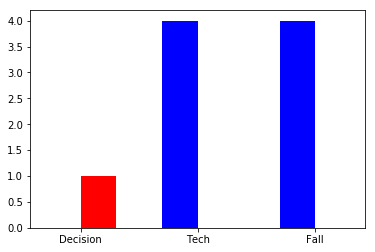

In [186]:
# results graph
pin_count = len(fm[fm.result=='WinF'])
tech_count = len(fm[fm.result=='WinTF'])
decision_count = len(fm[fm.result=='WinD'])
loss_decision_count = len(fm[fm.result=='LossD'])
loss_tech_count = len(fm[fm.result=='LossTF'])
loss_pin_count = len(fm[fm.result=='LossF'])

focus_results = (pin_count, tech_count, decision_count)
opp_results = (loss_decision_count, loss_tech_count, loss_pin_count)

ind = np.arange(len(focus_results))
width = 0.30

fig, ax = plt.subplots()
p1 = ax.bar(ind - width/2, focus_results, width, color='blue')
p2 = ax.bar(ind + width/2, opp_results, width, color='red')
ax.set_xticks(ind)
ax.set_xticklabels(('Decision', 'Tech', 'Fall'))
plt.show()

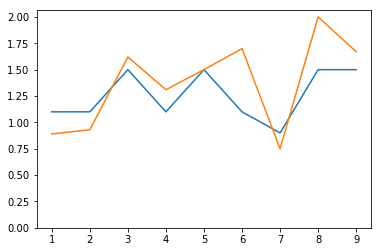

In [191]:
# npf time graph
# use this graph with the results graph
# add results line for comparison?
plt.plot(list(range(1,len(fm)+1)), fm.num_result)
plt.plot(list(range(1,len(fm)+1)), fm.npf)
plt.xticks(range(1, len(fm)+1), [str(i) for i in range(1, len(fm)+1)])
plt.yticks(np.arange(0,2.25,step=0.25))
plt.show()

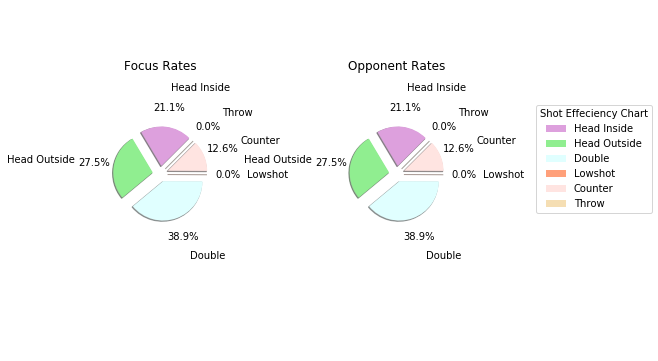

In [184]:
# shot chart
labels = ['Head Inside', 'Head Outside', 'Double', 'Lowshot', 'Counter', 'Throw']
colors = ['plum', 'lightgreen', 'lightcyan', 'lightsalmon', 'mistyrose', 'wheat']
rates = [fm.hi_rate.mean(), fm.ho_rate.mean(), fm.d_rate.mean(), fm.ls_rate.mean(), fm.gb_rate.mean(), fm.t_rate.mean()]
opp_rates = [fm.opp_hi_rate.mean(), fm.opp_ho_rate.mean(), fm.opp_d_rate.mean(), fm.opp_ls_rate.mean(), fm.gb_rate.mean(), fm.opp_t_rate.mean()]
explode = (0.2, 0.2, 0.2, 0.2, 0.2, 0.2)  # only "explode" the 2nd slice 

# Make figure and axes
fig, axs = plt.subplots(1, 3)

# A standard pie plot
axs[0].pie(rates, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True, startangle=45,
          pctdistance=1.5, labeldistance=2.0, colors=colors)
axs[0].set_title('Focus Rates', y=1.5)
axs[1].axis('off')
axs[2].pie(rates, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True, startangle=45,
          pctdistance=1.5, labeldistance=2.0, colors=colors)
axs[2].set_title('Opponent Rates', y=1.5)
axs[2].legend(axs,labels=labels,
          title="Shot Effeciency Chart",
          loc='upper center',bbox_to_anchor=(2.5, 1.25), ncol=1)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [30]:
fm.columns

Index(['apm', 'd_rate', 'da', 'date', 'dc2', 'dc4', 'duration', 'exposure',
       'focus_id', 'focus_score', 'focus_team_id', 'gb_rate', 'gba', 'gbc2',
       'gut', 'hi_rate', 'hia', 'hic2', 'hic4', 'ho_rate', 'hoa', 'hoc2',
       'hoc4', 'leg_lace', 'ls_rate', 'lsa', 'lsc2', 'lsc4', 'matchID', 'mov',
       'npf', 'opp_apm', 'opp_d_rate', 'opp_da', 'opp_dc2', 'opp_dc4',
       'opp_exposure', 'opp_gb_rate', 'opp_gba', 'opp_gbc2', 'opp_gbc4',
       'opp_gut', 'opp_hi_rate', 'opp_hia', 'opp_hic2', 'opp_hic4',
       'opp_ho_rate', 'opp_hoa', 'opp_hoc2', 'opp_hoc4', 'opp_leg_lace',
       'opp_ls_rate', 'opp_lsa', 'opp_lsc2', 'opp_lsc4', 'opp_npf',
       'opp_passive', 'opp_pushout', 'opp_recovery', 'opp_score', 'opp_t_rate',
       'opp_ta', 'opp_tc2', 'opp_tc4', 'opp_team_id', 'opp_turn',
       'opp_violation', 'opp_vs', 'opponent_id', 'passive', 'pushout',
       'recovery', 'result', 't_rate', 'ta', 'tc2', 'tc4', 'turn', 'violation',
       'vs', 'weight', 'passive_dif', 'num_r

11.11111111111111